ResNet极大地改变了如何参数化深层网络中函数的观点。稠密连接网络（DenseNet）(Huang et al., 2017)在某种程度上是ResNet的逻辑扩展。
- ResNet和DenseNet的关键区别在于，DenseNet输出是连接（用图中的[, ]表示）而不是
如ResNet的简单相加。

- 稠密网络主要由2部分构成：稠密块（dense block）和过渡层（transition layer）。前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

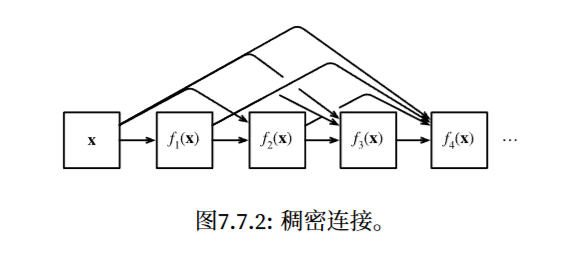

In [3]:
import torch
from torch import nn
from d2l import torch as d2l
def conv_block(input_channels, num_channels):
    return nn.Sequential(
    nn.BatchNorm2d(input_channels), nn.ReLU(),
    nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [5]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
        num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)
    def forward(self, X):
        for blk in self.net:
            Y=blk(X)
            #连接通道维度上每个块的输入和输出
            X=torch.cat((X,Y),dim=1)
        return X

在下面的例子中，我们定义一个有2个输出通道数为10的DenseBlock。使用通道数为3的输入时，我们会得到
通道数为3 + 2 × 10 = 23的输出。卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称
为增长率（growth rate）。

In [6]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。而过渡层可以用来控制模型复杂度。
它通过1 × 1卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。

In [7]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [8]:
blk=transition_block(23,10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [9]:
#构造DenseNet
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [10]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [11]:
#与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

loss 0.141, train acc 0.949, test acc 0.908
2429.0 examples/sec on cuda:0


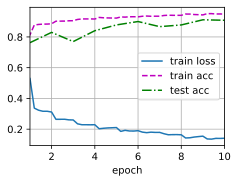

In [12]:
#训练模型
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())